In [ ]:
!pip install pandas fiona shapely pyproj rtree pygeos
!pip install geopandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import datetime
import requests

import ast

import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

import rtree

import folium
from folium.plugins import MarkerCluster

import xgboost

from sklearn.model_selection import train_test_split

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="example app")

sp = gpd.read_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/Shapes_base/Ubatuba_IBGE.shp')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Tratamento Base Zap Imoveis

In [4]:
zap = pd.read_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/IMOBILIARIAS/SCRAPPERS/Zap_Imoveis_pages_lastversion_geoloc.xlsx')

valor = zap.valor.str.split(' ',  expand=True).iloc[:,1]
valor = valor.str.replace('.','',regex=True)
valor = pd.to_numeric(valor)

dorm = zap.dorm.str.split('-',  expand=True)
dorm = dorm.ffill(axis=1).iloc[:,1]
dorm = pd.to_numeric(dorm)

banh = zap.banheiro.str.split('-',  expand=True)
banh = banh.ffill(axis=1).iloc[:,1]
banh = pd.to_numeric(banh)

vagas = zap.vagas.str.split('-',  expand=True)
vagas = vagas.ffill(axis=1).iloc[:,1]
vagas = pd.to_numeric(vagas)
vagas.fillna(0,inplace=True)

area = zap.area_tot.str.split('-',  expand=True)
area1 = area.iloc[:,0].str.split(' ',  expand=True).iloc[:,0]
area2 = area.iloc[:,1].str.split(' ',  expand=True).iloc[:,1]
area = pd.concat([area2,area1],axis=1,join='outer').bfill(axis=1).iloc[:,0]
area = pd.to_numeric(area)

zap['valor'] = valor
zap['dorm'] = dorm
zap['banheiro'] = banh
zap['vagas'] = vagas
zap['area_tot'] = area

zap.to_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/IMOBILIARIAS/SCRAPPERS/Zap_Imoveis_pages_lastversion_geoloc_tratado.xlsx')

In [5]:
gdf_zap = gpd.GeoDataFrame(zap,geometry=gpd.points_from_xy(zap.lon, zap.lat))

#Selecionando dentro das coordendas
xmin, ymin, xmax, ymax = -45.4, -23.6, -44.8, -23.,
gdf_zap = gdf_zap.cx[xmin:xmax, ymin:ymax]

gdf_zap.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

gdf_zap['indice'] = np.arange(1,len(gdf_zap)+1,1)

gdf_zap = gdf_zap[gdf_zap.valor < 6000000]


/usr/local/lib/python3.7/dist-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


# Base da CETESB de Enterococcus

In [6]:
df_cetesb = pd.read_csv('/content/drive/MyDrive/PROCAM/Dissertação/dados/CETESB/sp_beaches.csv')
df_cetesb.index = pd.to_datetime(df_cetesb.Date)

cetesb_media = pd.DataFrame(index = ['count','mean','std','min','25%','50%','75%','max'])
for praia in df_cetesb[df_cetesb.City == 'UBATUBA'].Beach.unique():

  cetesb_media[praia] = df_cetesb[df_cetesb.Beach == praia].describe().values

cetesb_media.drop(['LAGOA PRUMIRIM'],axis=1,inplace=True)

geo_CETESB = gpd.read_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/Shapes/CETESB_Qual-Praias.shp',encoding='utf')
geo_CETESB['NAME'] = cetesb_media.columns
geo_CETESB.index = geo_CETESB.NAME

geo_CETESB.crs = "epsg:4326"
geo_CETESB.to_crs({'init': 'epsg:4326'})

cetesb_media = cetesb_media.T

cetesb_media = gpd.GeoDataFrame(cetesb_media)

cetesb_media = cetesb_media.join(geo_CETESB)
cetesb_media.drop(['NAME','LAYER','KML_STYLE','KML_FOLDER'],axis=1,inplace=True)

gdf_zap = gpd.sjoin_nearest(gdf_zap,cetesb_media,how='left',distance_col='dist')
gdf_zap.drop(['count','std','min','25%','50%','75%','index_right'],axis=1,inplace=True)

gdf_zap.crs = "epsg:4326"

gdf_zap.to_crs({'init': 'epsg:4326'})

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_

,endereco,valor,dorm,banheiro,vagas,area_tot,desc,data,loc,point,lat,lon,altitude,geometry,indice,mean,max,dist
3,"Itaguá, Ubatuba",450000,1,1,1.0,125,"Ubatuba, casa no itagua, ótima localização, 02...",2021-11-08,"Itaguá, Ubatuba, Região Imediata de Caraguatat...","(-23.454413, -45.0670857, 0.0)",-23.454413,-45.067086,0.0,POINT (-45.06709 -23.45441),1,77.325792,1700.0,0.005915
4,"Jardim Carolina, Ubatuba",850000,2,1,3.0,378,"Ubatuba - Jardim Carolina, Lindo sobrado bem a...",2021-11-08,"Jardim Carolina, Ubatuba, Região Imediata de C...","(-23.4390716, -45.0951878, 0.0)",-23.439072,-45.095188,0.0,POINT (-45.09519 -23.43907),2,43.731765,820.0,0.026220
6,"PRAIA DE MARANDUBA, Ubatuba",720000,3,3,3.0,100,"Casa bem construída e com amplo terreno, em lo...",2021-11-08,"Praia de Maranduba, Maranduba, Ubatuba, Região...","(-23.54028195, -45.228936771552114, 0.0)",-23.540282,-45.228937,0.0,POINT (-45.22894 -23.54028),3,29.300905,600.0,0.001503
7,"Lagoinha, Ubatuba",430000,4,3,2.0,140,Sobrado bem estruturado em rua sem saída divid...,2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),4,19.781176,540.0,0.007070
8,"Praia Dura, Ubatuba",290000,3,1,1.0,160,ÓTIMA OPORTUNIDADE DE ADQUIRIR SEU IMÓVEL EM U...,2021-11-08,"Praia Dura, Rio Escuro, Ubatuba, Região Imedia...","(-23.49685015, -45.17430491470031, 0.0)",-23.496850,-45.174305,0.0,POINT (-45.17430 -23.49685),5,39.576471,780.0,0.003763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,"Lagoinha, Ubatuba",3000000,6,1,10.0,500,Código 639 - Propriedade composta de :casa pri...,2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),1051,19.781176,540.0,0.007070
1195,"BR-101, Praia do Itamambuca",3500000,4,6,5.0,313,"Linda casa na encosta. Moderna e espaçosa, a c...",2021-11-08,"Rodovia Governador Mário Covas, Praia de Itama...","(-23.393856, -45.0113234, 0.0)",-23.393856,-45.011323,0.0,POINT (-45.01132 -23.39386),1052,13.733032,252.0,0.011510
1196,"Lagoinha, Ubatuba",3000000,6,6,3.0,400,"Código: 961 - Casa alto padrão em condomínio, ...",2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),1053,19.781176,540.0,0.007070
1198,"Centro, Ubatuba",990000,6,5,0.0,548,Linda residência localizada no centro de Ubatu...,2021-11-08,"Centro, Ubatuba, Região Imediata de Caraguatat...","(-23.4352739, -45.0722073, 0.0)",-23.435274,-45.072207,0.0,POINT (-45.07221 -23.43527),1054,43.731765,820.0,0.003040


# Leitura shape Setores Censitários

In [7]:
censo_2010 = gpd.read_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/IBGE/UBATUBA_IBGE_2010_deslocado.shp',encoding='utf')
censo_2010 = censo_2010.drop(censo_2010.columns[0:2],axis=1)
censo_2010 = censo_2010.drop(censo_2010.columns[1:30],axis=1)
censo_2010 = censo_2010.drop(censo_2010.columns[1:3],axis=1)
censo_2010 = censo_2010.drop(['populacao'],axis=1)
censo_2010 = censo_2010.drop(censo_2010.columns[5:12],axis=1)
censo_2010 = censo_2010.dropna()
censo_2010 = pd.concat([censo_2010,pd.get_dummies(censo_2010.TIPO)],axis=1)
censo_2010 = censo_2010.drop(['TIPO'],axis=1)

censo_2010.columns = ['Domicilios','Residentes','Residentes_por_domicilio','Variancia_moradores','Rendimento_mensal_nominal',
                      'geometry','RURAL','URBANO']

censo_2010['Domicilios'] = pd.to_numeric(censo_2010.Domicilios)
censo_2010['Residentes'] = pd.to_numeric(censo_2010.Residentes)
censo_2010['Residentes_por_domicilio'] = pd.to_numeric(censo_2010.Residentes_por_domicilio)
censo_2010['Rendimento_mensal_nominal'] = pd.to_numeric(censo_2010.Rendimento_mensal_nominal)

censo_2010 = censo_2010.drop(['Variancia_moradores'],axis=1)

censo_2010['area_km2'] = (censo_2010.geometry.to_crs(32723).area)/1000000
censo_2010['densidade_hab_km2'] = (censo_2010.Residentes)/(censo_2010.area_km2)

censo_2010.geometry.to_crs(4326)

censo_2010['Rendimento_per_capita'] = censo_2010.Rendimento_mensal_nominal/censo_2010.Residentes

censo_2010 = censo_2010[['RURAL','URBANO','Domicilios','Residentes','Residentes_por_domicilio','Rendimento_per_capita','densidade_hab_km2','geometry']]

censo_2010.to_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/IBGE/UBATUBA_IBGE_2010_deslocado_complemento.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


# Join de Censo com Zap Imoveis

In [8]:
gdf_zap = gdf_zap.sjoin_nearest(censo_2010,how='left')
gdf_zap.drop(['index_right'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:2057: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4674

  distance_col=distance_col,
/usr/local/lib/python3.7/dist-packages/geopandas/array.py:348: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stacklevel=stacklevel,


In [ ]:
# fig,ax = plt.subplots(figsize=(10,10))
# censo_2010.plot(ax=ax,column = 'densidade_hab_km2')

# fig,ax = plt.subplots(figsize=(10,10))
# censo_2010.plot(ax=ax,column = 'Rendimento_mensal_nominal')

In [ ]:
# censo_2010 = gpd.read_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/IBGE/UBATUBA_IBGE_2010_deslocado.shp',encoding='utf')
# censo_2010 = censo_2010.drop(censo_2010.columns[0:1],axis=1)
# censo_2010 = censo_2010.drop(censo_2010.columns[1:],axis=1)

# censo_2010

# Preparação da base Google Places

In [9]:
f = pd.read_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/GOOGLE_PLACES/GDF_Scrapy_Ubatuba.xlsx')
gdf_google = gpd.GeoDataFrame(f,geometry=gpd.points_from_xy(f.lon, f.lat))
gdf_google = gdf_google.drop_duplicates(subset=['place_id'])

#seleção de colunas
gdf_google = gdf_google[['geometry','name','types','vicinity']]

def str_to_list(tipo):
  tipo = ast.literal_eval(tipo)
  tipo = [n.strip() for n in tipo]

  return tipo

unique = []
for tipo in gdf_google.types:  
  tipo = str_to_list(tipo)

  for case in tipo:

    if case not in unique:
      unique.append(case)

    else:
      pass

for uni in unique:
  gdf_google[uni] = 0

for i in gdf_google.index:
  tipo = str_to_list(gdf_google.loc[i]['types'])

  for case in tipo:
    gdf_google.loc[i,case] = 1

In [13]:
gdf_zap

,endereco,valor,dorm,banheiro,vagas,area_tot,desc,data,loc,point,lat,lon,altitude,geometry,indice,mean,max,dist,RURAL,URBANO,Domicilios,Residentes,Residentes_por_domicilio,Rendimento_per_capita,densidade_hab_km2
3,"Itaguá, Ubatuba",450000,1,1,1.0,125,"Ubatuba, casa no itagua, ótima localização, 02...",2021-11-08,"Itaguá, Ubatuba, Região Imediata de Caraguatat...","(-23.454413, -45.0670857, 0.0)",-23.454413,-45.067086,0.0,POINT (-45.06709 -23.45441),1,77.325792,1700.0,0.005915,0,1,64,168,2.63,29144.344524,1722.020989
4,"Jardim Carolina, Ubatuba",850000,2,1,3.0,378,"Ubatuba - Jardim Carolina, Lindo sobrado bem a...",2021-11-08,"Jardim Carolina, Ubatuba, Região Imediata de C...","(-23.4390716, -45.0951878, 0.0)",-23.439072,-45.095188,0.0,POINT (-45.09519 -23.43907),2,43.731765,820.0,0.026220,0,1,183,576,3.15,2240.350937,1083.235780
6,"PRAIA DE MARANDUBA, Ubatuba",720000,3,3,3.0,100,"Casa bem construída e com amplo terreno, em lo...",2021-11-08,"Praia de Maranduba, Maranduba, Ubatuba, Região...","(-23.54028195, -45.228936771552114, 0.0)",-23.540282,-45.228937,0.0,POINT (-45.22894 -23.54028),3,29.300905,600.0,0.001503,0,1,65,178,2.74,1759.690730,232.450940
7,"Lagoinha, Ubatuba",430000,4,3,2.0,140,Sobrado bem estruturado em rua sem saída divid...,2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),4,19.781176,540.0,0.007070,0,1,86,254,2.95,8009.921024,206.406997
8,"Praia Dura, Ubatuba",290000,3,1,1.0,160,ÓTIMA OPORTUNIDADE DE ADQUIRIR SEU IMÓVEL EM U...,2021-11-08,"Praia Dura, Rio Escuro, Ubatuba, Região Imedia...","(-23.49685015, -45.17430491470031, 0.0)",-23.496850,-45.174305,0.0,POINT (-45.17430 -23.49685),5,39.576471,780.0,0.003763,0,1,54,157,2.91,35632.981911,62.051614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,"Lagoinha, Ubatuba",3000000,6,1,10.0,500,Código 639 - Propriedade composta de :casa pri...,2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),1051,19.781176,540.0,0.007070,0,1,86,254,2.95,8009.921024,206.406997
1195,"BR-101, Praia do Itamambuca",3500000,4,6,5.0,313,"Linda casa na encosta. Moderna e espaçosa, a c...",2021-11-08,"Rodovia Governador Mário Covas, Praia de Itama...","(-23.393856, -45.0113234, 0.0)",-23.393856,-45.011323,0.0,POINT (-45.01132 -23.39386),1052,13.733032,252.0,0.011510,0,1,182,473,2.60,7836.953044,138.411212
1196,"Lagoinha, Ubatuba",3000000,6,6,3.0,400,"Código: 961 - Casa alto padrão em condomínio, ...",2021-11-08,"Lagoinha, Ubatuba, Região Imediata de Caraguat...","(-23.5133746, -45.2018949, 0.0)",-23.513375,-45.201895,0.0,POINT (-45.20189 -23.51337),1053,19.781176,540.0,0.007070,0,1,86,254,2.95,8009.921024,206.406997
1198,"Centro, Ubatuba",990000,6,5,0.0,548,Linda residência localizada no centro de Ubatu...,2021-11-08,"Centro, Ubatuba, Região Imediata de Caraguatat...","(-23.4352739, -45.0722073, 0.0)",-23.435274,-45.072207,0.0,POINT (-45.07221 -23.43527),1054,43.731765,820.0,0.003040,0,1,38,87,2.29,58118.132069,1971.265149


In [14]:
gdf_google.to_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/GOOGLE_PLACES/Google_Places_Ubatuba.shp')

gdf_zap_export = gdf_zap.drop(['data'],axis=1)
gdf_zap_export.to_file('/content/drive/MyDrive/PROCAM/Dissertação/GIS/ZAP_IMOVEIS/Zap_Imoveis_Ubatuba.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  after removing the cwd from sys.path.


# Criação de Buffers na base do Zap Imoveis

In [ ]:
def create_base_buffer(gdf_zap,gdf_google, buffer='0.01'):

  gdf_zap_buffer = gdf_zap.copy()
  gdf_zap_buffer['geometry'] = gdf_zap_buffer.buffer(buffer)

  join = gdf_zap_buffer.sjoin(gdf_google,how='left')

  soma = join.groupby('indice').sum().iloc[:,19:]

  gdf_zap = gdf_zap.join(soma,on='indice')

  gdf_zap.to_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Base_join_buffer_{}.xlsx'.format(buffer)) 

  return join 


In [ ]:
for buff in [0.002,0.005,0.01]:

  a = create_base_buffer(gdf_zap,gdf_google, buffer=buff)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:19

<Figure size 1440x720 with 0 Axes>

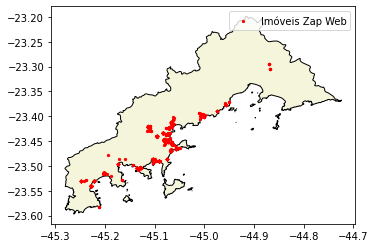

In [ ]:
plt.figure(figsize=(20,10))
ax=sp.plot(facecolor='beige',edgecolor='k')
gdf_zap.plot(ax=ax,color='r',markersize=5)

plt.legend(['Imóveis Zap Web'])

<IPython.core.display.Javascript object>


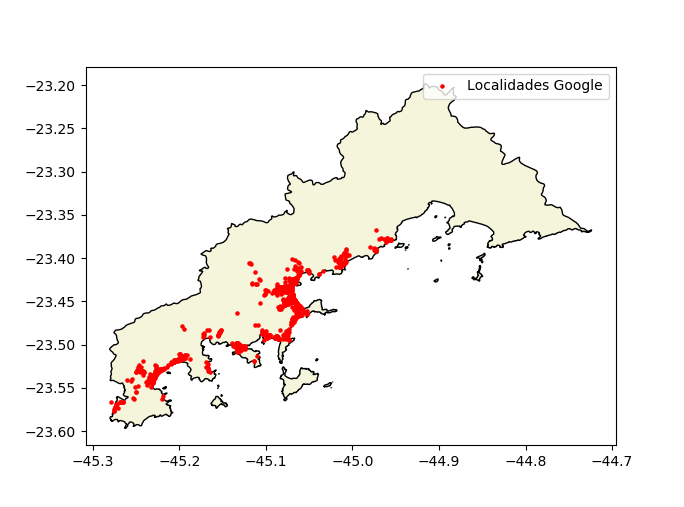

In [ ]:
ax=sp.plot(facecolor='beige',edgecolor='k')
gdf_google.plot(ax=ax,color='r',markersize=5)

plt.legend(['Localidades Google'])